In [1]:
#Fazendo as importações necessárias
import torch
from torchsummary import summary 
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.cuda import device
import pandas as pd
import torchaudio
import os
import re
import numpy as np
import librosa.display
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa

In [2]:
#Acessando a gpu
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"using {device}")

using cuda


In [4]:
#Classe para criação do dataloader, com ela conseguimos abrir os arquivos de áudio a serem utilizados
from torch.utils.data import Dataset
class SerDataset (Dataset):

    def __init__(self,
                 annotations_file,
                 transformation,
                 target_sample_rate,
                 num_samples,device):
        self.annotations = pd.read_csv(annotations_file)
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.cache = dict()
        

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self,index):
        if index in self.cache:
          return self.cache[index]
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        label_dict = {"fear":0, "disgust":1, "happy":2, "sad":3, "neutral":4, "angry":5, "surprise":6}
        label2 = label_dict[label]
        self.cache[index] = signal, label2
        return signal, label2

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            resampler.to(self.device)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self,index):
        return self.annotations.iloc[index,0]
    def _get_audio_sample_label(self,index):
        return self.annotations.iloc[index,1]


In [106]:
#Captando os dados de treino
ANNOTATIONS_FILE = "metadata/treino.csv"
SAMPLE_RATE = 16000
NUM_SAMPLES = 4*16000

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)
train_data = SerDataset(ANNOTATIONS_FILE,mel_spectrogram,SAMPLE_RATE,NUM_SAMPLES,device)

print(f"There are {len(train_data)} samples in the dataset.")

There are 17294 samples in the dataset.


In [107]:
#Fazendo a partição dos dados em treino e validação
aux_size = len(train_data)
train_data, valid_data =  torch.utils.data.random_split(train_data, [int(np.ceil(aux_size*0.80)), int(np.floor(aux_size*0.20))])


In [108]:
len(valid_data)

3458

In [109]:
#Criando os dataloaders
batch_size= 16
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=True)

In [110]:
#Montando a rede neural 
class CNNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
               out_channels=256,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3)
        )
    
        self.dropout = nn.Dropout()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(8192, 7)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.dropout(x)
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

In [111]:
cnn = CNNNetwork().to(device)

In [112]:
summary(cnn.cuda(),(1,64,126))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 66, 128]             320
              ReLU-2          [-1, 32, 66, 128]               0
         MaxPool2d-3           [-1, 32, 33, 64]               0
           Dropout-4           [-1, 32, 33, 64]               0
            Conv2d-5           [-1, 64, 33, 64]          51,264
              ReLU-6           [-1, 64, 33, 64]               0
         MaxPool2d-7           [-1, 64, 16, 32]               0
           Dropout-8           [-1, 64, 16, 32]               0
            Conv2d-9          [-1, 128, 18, 34]          73,856
             ReLU-10          [-1, 128, 18, 34]               0
        MaxPool2d-11           [-1, 128, 9, 17]               0
          Dropout-12           [-1, 128, 9, 17]               0
           Conv2d-13           [-1, 256, 9, 17]         819,456
      BatchNorm2d-14           [-1, 256

In [115]:
from tqdm import tqdm
#função que irá realizar o treino e a validação
def train(loss_func, opt, epochs, model, train_loader, valid_loader):

  #lista que irá armazenar a loss de treino de cada época
  losses_train = []

  #lista que irá armazenar a loss de validação de cada época
  losses_val = []

  #lista que irá armazenar a acurácia de treino de cada época
  acc_train = []

  #lista que irá armazenar a acurácia de validação de cada época
  acc_valid = []

  #treino
  for epoch in range(1,epochs+1):

      #lista que irá armazenar a loss de treino de cada batch
      loss_train = []

      #lista que irá armazenar a loss de validação de cada batch
      loss_val = []

      #variável que armazenar a quantidade de acertos no treino
      corretos_train = 0

      model.train()

      for batch_index, (inp_train, label_train) in enumerate(tqdm(train_loader)):
          
          #alocando o input e a label na GPU
          inp_train, label_train = inp_train.to(device),label_train.to(device)
           

          #predição do modelo em cima do input
          preds = model(inp_train)

          #cálculo da loss de treino
          loss_calc = loss_func(preds, label_train)

          #armazenando a loss na lista de loss de treino dos batches
          loss_train.append(loss_calc.item())

          #incrementando a quantidade de acertos no treino
          corretos_train += (preds.argmax(1) == label_train).type(torch.float).sum().item()

          #zerando o gradiente para realizar o backpropagation
          opt.zero_grad()

          #calculando o gradiente
          loss_calc.backward()

          #atualizando os pesos do modelo
          opt.step()
    
      #adicionando a loss de treino do batch à lista de loss das épocas
      losses_train.append(np.mean(loss_train))

      #adicionando a acurácia da época à lista de acurácia de treino das épocas
      acc_train.append(corretos_train/len(train_loader.dataset))

      ''#validação
      #variável que armazena o número de acertos na validação
      corretos_valid = 0
      model.eval()
      with torch.no_grad():
        for inp_valid, label_valid in valid_loader:
            
            #alocando o input e a label na GPU
            inp_valid,label_valid = inp_valid.to(device),label_valid.to(device)
            
                
            #predição do modelo em cima do input
            preds2 = model(inp_valid)
    


            #cálculo da loss de validação
            loss_calc = loss_func(preds2, label_valid)

            #armazenando a loss na lista de loss de validação dos batches
            loss_val.append(loss_calc.item())
            #incrementando a quantidade de acertos na validação
            corretos_valid += (preds2.argmax(1) == label_valid).type(torch.float).sum().item()

        #adicionando a loss de validação do batch à lista de loss das épocas
        losses_val.append(np.mean(loss_val))

        #adicionando a acurácia da época à lista de acurácia de validação das épocas
        acc_valid.append(corretos_valid/len(valid_loader.dataset))    
        
      #imprimindo a loss de treino, de validação e acurácia de treino e acurácia de validação de cada época
      print(f"\nEpoch: {epoch} | \t Loss(train): {round(sum(loss_train)/len(loss_train),2)} | \t Loss(validation): {round(sum(loss_val)/len(loss_val),2)} | \t Accuracy (train): {round(corretos_train/len(train_loader.dataset),3)*100}% | \t Accuracy (validation): {round(corretos_valid/len(valid_loader.dataset),3)*100}%")

  #criação de gráficos para analisar o comportamento
  #da acurácia e da loss ao longo das épocas
  print("\n")
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
  ax1.set_title("Accuracy Analysis")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Accuracy")
  ax1.plot(range(1,epochs+1),acc_train)
  ax1.plot(range(1,epochs+1),acc_valid)
  ax1.legend(['Train','Validation'])

  ax2.set_title("Loss Analysis")
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Loss")
  ax2.plot(range(1,epochs+1),losses_train)
  ax2.plot(range(1,epochs+1),losses_val)
  ax2.legend(['Train','Validation'])

  return acc_train, acc_valid, losses_train, losses_val

In [116]:
cnn = CNNNetwork()
cnn.to(device)
lrt = 0.001
epochs = 120
loss_func = nn.CrossEntropyLoss()
optm = torch.optim.Adam(cnn.parameters(), lr = lrt)

100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [01:27<00:00,  9.89it/s]



Epoch: 1 | 	 Loss(train): 2.01 | 	 Loss(validation): 1.69 | 	 Accuracy (train): 31.4% | 	 Accuracy (validation): 39.4%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 90.87it/s]



Epoch: 2 | 	 Loss(train): 1.76 | 	 Loss(validation): 1.66 | 	 Accuracy (train): 34.8% | 	 Accuracy (validation): 40.300000000000004%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:08<00:00, 97.44it/s]



Epoch: 3 | 	 Loss(train): 1.69 | 	 Loss(validation): 1.74 | 	 Accuracy (train): 35.6% | 	 Accuracy (validation): 37.5%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:08<00:00, 97.20it/s]



Epoch: 4 | 	 Loss(train): 1.65 | 	 Loss(validation): 1.66 | 	 Accuracy (train): 36.4% | 	 Accuracy (validation): 37.1%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:08<00:00, 96.62it/s]



Epoch: 5 | 	 Loss(train): 1.63 | 	 Loss(validation): 1.63 | 	 Accuracy (train): 36.7% | 	 Accuracy (validation): 38.1%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:08<00:00, 97.36it/s]



Epoch: 6 | 	 Loss(train): 1.61 | 	 Loss(validation): 1.62 | 	 Accuracy (train): 37.1% | 	 Accuracy (validation): 39.0%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 88.57it/s]



Epoch: 7 | 	 Loss(train): 1.6 | 	 Loss(validation): 1.6 | 	 Accuracy (train): 38.3% | 	 Accuracy (validation): 38.1%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 93.83it/s]



Epoch: 8 | 	 Loss(train): 1.59 | 	 Loss(validation): 1.6 | 	 Accuracy (train): 38.4% | 	 Accuracy (validation): 39.4%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 94.22it/s]



Epoch: 9 | 	 Loss(train): 1.57 | 	 Loss(validation): 1.62 | 	 Accuracy (train): 39.1% | 	 Accuracy (validation): 40.5%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 93.48it/s]



Epoch: 10 | 	 Loss(train): 1.55 | 	 Loss(validation): 1.54 | 	 Accuracy (train): 40.1% | 	 Accuracy (validation): 42.699999999999996%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 94.19it/s]



Epoch: 11 | 	 Loss(train): 1.54 | 	 Loss(validation): 1.62 | 	 Accuracy (train): 41.0% | 	 Accuracy (validation): 40.2%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.61it/s]



Epoch: 12 | 	 Loss(train): 1.52 | 	 Loss(validation): 1.6 | 	 Accuracy (train): 41.6% | 	 Accuracy (validation): 39.4%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 91.32it/s]



Epoch: 13 | 	 Loss(train): 1.49 | 	 Loss(validation): 1.52 | 	 Accuracy (train): 43.2% | 	 Accuracy (validation): 42.3%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 94.28it/s]



Epoch: 14 | 	 Loss(train): 1.49 | 	 Loss(validation): 1.48 | 	 Accuracy (train): 44.0% | 	 Accuracy (validation): 45.1%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 93.55it/s]



Epoch: 15 | 	 Loss(train): 1.46 | 	 Loss(validation): 1.49 | 	 Accuracy (train): 44.800000000000004% | 	 Accuracy (validation): 45.1%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 90.42it/s]



Epoch: 16 | 	 Loss(train): 1.46 | 	 Loss(validation): 1.51 | 	 Accuracy (train): 44.800000000000004% | 	 Accuracy (validation): 46.400000000000006%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.55it/s]



Epoch: 17 | 	 Loss(train): 1.46 | 	 Loss(validation): 1.47 | 	 Accuracy (train): 44.7% | 	 Accuracy (validation): 46.0%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.63it/s]



Epoch: 18 | 	 Loss(train): 1.44 | 	 Loss(validation): 1.47 | 	 Accuracy (train): 45.2% | 	 Accuracy (validation): 44.2%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 93.00it/s]



Epoch: 19 | 	 Loss(train): 1.42 | 	 Loss(validation): 1.38 | 	 Accuracy (train): 45.7% | 	 Accuracy (validation): 48.5%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.02it/s]



Epoch: 20 | 	 Loss(train): 1.42 | 	 Loss(validation): 1.43 | 	 Accuracy (train): 46.0% | 	 Accuracy (validation): 46.6%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.91it/s]



Epoch: 21 | 	 Loss(train): 1.41 | 	 Loss(validation): 1.42 | 	 Accuracy (train): 46.6% | 	 Accuracy (validation): 47.4%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.33it/s]



Epoch: 22 | 	 Loss(train): 1.41 | 	 Loss(validation): 1.44 | 	 Accuracy (train): 46.800000000000004% | 	 Accuracy (validation): 45.6%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.76it/s]



Epoch: 23 | 	 Loss(train): 1.41 | 	 Loss(validation): 1.42 | 	 Accuracy (train): 46.9% | 	 Accuracy (validation): 47.4%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.62it/s]



Epoch: 24 | 	 Loss(train): 1.39 | 	 Loss(validation): 1.43 | 	 Accuracy (train): 47.8% | 	 Accuracy (validation): 47.9%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.38it/s]



Epoch: 25 | 	 Loss(train): 1.39 | 	 Loss(validation): 1.47 | 	 Accuracy (train): 47.3% | 	 Accuracy (validation): 44.9%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.77it/s]



Epoch: 26 | 	 Loss(train): 1.37 | 	 Loss(validation): 1.4 | 	 Accuracy (train): 48.1% | 	 Accuracy (validation): 48.199999999999996%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.10it/s]



Epoch: 27 | 	 Loss(train): 1.38 | 	 Loss(validation): 1.43 | 	 Accuracy (train): 48.3% | 	 Accuracy (validation): 47.199999999999996%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.37it/s]



Epoch: 28 | 	 Loss(train): 1.37 | 	 Loss(validation): 1.36 | 	 Accuracy (train): 48.4% | 	 Accuracy (validation): 50.2%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.68it/s]



Epoch: 29 | 	 Loss(train): 1.35 | 	 Loss(validation): 1.4 | 	 Accuracy (train): 48.9% | 	 Accuracy (validation): 49.1%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.36it/s]



Epoch: 30 | 	 Loss(train): 1.34 | 	 Loss(validation): 1.39 | 	 Accuracy (train): 49.4% | 	 Accuracy (validation): 48.8%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.85it/s]



Epoch: 31 | 	 Loss(train): 1.35 | 	 Loss(validation): 1.35 | 	 Accuracy (train): 49.0% | 	 Accuracy (validation): 50.0%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.58it/s]



Epoch: 32 | 	 Loss(train): 1.34 | 	 Loss(validation): 1.41 | 	 Accuracy (train): 49.2% | 	 Accuracy (validation): 47.9%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 90.82it/s]



Epoch: 33 | 	 Loss(train): 1.34 | 	 Loss(validation): 1.35 | 	 Accuracy (train): 49.5% | 	 Accuracy (validation): 50.3%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 90.77it/s]



Epoch: 34 | 	 Loss(train): 1.32 | 	 Loss(validation): 1.36 | 	 Accuracy (train): 50.0% | 	 Accuracy (validation): 49.7%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.09it/s]



Epoch: 35 | 	 Loss(train): 1.32 | 	 Loss(validation): 1.34 | 	 Accuracy (train): 49.8% | 	 Accuracy (validation): 50.1%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.14it/s]



Epoch: 36 | 	 Loss(train): 1.32 | 	 Loss(validation): 1.33 | 	 Accuracy (train): 49.9% | 	 Accuracy (validation): 50.5%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.37it/s]



Epoch: 37 | 	 Loss(train): 1.32 | 	 Loss(validation): 1.35 | 	 Accuracy (train): 50.4% | 	 Accuracy (validation): 49.2%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 91.98it/s]



Epoch: 38 | 	 Loss(train): 1.3 | 	 Loss(validation): 1.35 | 	 Accuracy (train): 51.4% | 	 Accuracy (validation): 49.0%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 91.99it/s]



Epoch: 39 | 	 Loss(train): 1.3 | 	 Loss(validation): 1.34 | 	 Accuracy (train): 51.5% | 	 Accuracy (validation): 50.1%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 91.71it/s]



Epoch: 40 | 	 Loss(train): 1.3 | 	 Loss(validation): 1.35 | 	 Accuracy (train): 50.9% | 	 Accuracy (validation): 49.2%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.31it/s]



Epoch: 41 | 	 Loss(train): 1.28 | 	 Loss(validation): 1.39 | 	 Accuracy (train): 51.7% | 	 Accuracy (validation): 49.4%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.33it/s]



Epoch: 42 | 	 Loss(train): 1.28 | 	 Loss(validation): 1.33 | 	 Accuracy (train): 52.0% | 	 Accuracy (validation): 51.1%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 88.01it/s]



Epoch: 43 | 	 Loss(train): 1.28 | 	 Loss(validation): 1.31 | 	 Accuracy (train): 51.5% | 	 Accuracy (validation): 50.9%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 90.21it/s]



Epoch: 44 | 	 Loss(train): 1.27 | 	 Loss(validation): 1.32 | 	 Accuracy (train): 52.5% | 	 Accuracy (validation): 51.4%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 90.33it/s]



Epoch: 45 | 	 Loss(train): 1.27 | 	 Loss(validation): 1.33 | 	 Accuracy (train): 52.5% | 	 Accuracy (validation): 49.1%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 90.29it/s]



Epoch: 46 | 	 Loss(train): 1.26 | 	 Loss(validation): 1.31 | 	 Accuracy (train): 52.1% | 	 Accuracy (validation): 50.9%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 90.56it/s]



Epoch: 47 | 	 Loss(train): 1.25 | 	 Loss(validation): 1.31 | 	 Accuracy (train): 52.6% | 	 Accuracy (validation): 50.7%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 90.30it/s]



Epoch: 48 | 	 Loss(train): 1.24 | 	 Loss(validation): 1.31 | 	 Accuracy (train): 53.0% | 	 Accuracy (validation): 51.7%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 94.16it/s]



Epoch: 49 | 	 Loss(train): 1.25 | 	 Loss(validation): 1.33 | 	 Accuracy (train): 53.300000000000004% | 	 Accuracy (validation): 51.0%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 90.49it/s]



Epoch: 50 | 	 Loss(train): 1.24 | 	 Loss(validation): 1.32 | 	 Accuracy (train): 53.300000000000004% | 	 Accuracy (validation): 51.6%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.39it/s]



Epoch: 51 | 	 Loss(train): 1.23 | 	 Loss(validation): 1.33 | 	 Accuracy (train): 53.6% | 	 Accuracy (validation): 51.300000000000004%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.54it/s]



Epoch: 52 | 	 Loss(train): 1.23 | 	 Loss(validation): 1.29 | 	 Accuracy (train): 54.0% | 	 Accuracy (validation): 52.5%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 91.97it/s]



Epoch: 53 | 	 Loss(train): 1.21 | 	 Loss(validation): 1.31 | 	 Accuracy (train): 54.2% | 	 Accuracy (validation): 52.300000000000004%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.58it/s]



Epoch: 54 | 	 Loss(train): 1.21 | 	 Loss(validation): 1.27 | 	 Accuracy (train): 54.1% | 	 Accuracy (validation): 52.7%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 91.74it/s]



Epoch: 55 | 	 Loss(train): 1.21 | 	 Loss(validation): 1.28 | 	 Accuracy (train): 54.6% | 	 Accuracy (validation): 53.2%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.25it/s]



Epoch: 56 | 	 Loss(train): 1.2 | 	 Loss(validation): 1.28 | 	 Accuracy (train): 54.6% | 	 Accuracy (validation): 53.1%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.25it/s]



Epoch: 57 | 	 Loss(train): 1.19 | 	 Loss(validation): 1.29 | 	 Accuracy (train): 55.2% | 	 Accuracy (validation): 53.400000000000006%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 91.97it/s]



Epoch: 58 | 	 Loss(train): 1.18 | 	 Loss(validation): 1.29 | 	 Accuracy (train): 55.300000000000004% | 	 Accuracy (validation): 53.2%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 91.99it/s]



Epoch: 59 | 	 Loss(train): 1.18 | 	 Loss(validation): 1.26 | 	 Accuracy (train): 55.400000000000006% | 	 Accuracy (validation): 53.800000000000004%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 88.74it/s]



Epoch: 60 | 	 Loss(train): 1.18 | 	 Loss(validation): 1.28 | 	 Accuracy (train): 56.3% | 	 Accuracy (validation): 53.400000000000006%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 90.95it/s]



Epoch: 61 | 	 Loss(train): 1.18 | 	 Loss(validation): 1.28 | 	 Accuracy (train): 55.900000000000006% | 	 Accuracy (validation): 54.50000000000001%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 91.28it/s]



Epoch: 62 | 	 Loss(train): 1.17 | 	 Loss(validation): 1.28 | 	 Accuracy (train): 56.10000000000001% | 	 Accuracy (validation): 53.6%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 91.02it/s]



Epoch: 63 | 	 Loss(train): 1.17 | 	 Loss(validation): 1.26 | 	 Accuracy (train): 56.10000000000001% | 	 Accuracy (validation): 54.2%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 87.09it/s]



Epoch: 64 | 	 Loss(train): 1.16 | 	 Loss(validation): 1.27 | 	 Accuracy (train): 56.39999999999999% | 	 Accuracy (validation): 53.800000000000004%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:10<00:00, 81.45it/s]



Epoch: 65 | 	 Loss(train): 1.15 | 	 Loss(validation): 1.26 | 	 Accuracy (train): 56.39999999999999% | 	 Accuracy (validation): 54.0%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 91.52it/s]



Epoch: 66 | 	 Loss(train): 1.16 | 	 Loss(validation): 1.26 | 	 Accuracy (train): 56.10000000000001% | 	 Accuracy (validation): 54.2%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.48it/s]



Epoch: 67 | 	 Loss(train): 1.15 | 	 Loss(validation): 1.25 | 	 Accuracy (train): 56.99999999999999% | 	 Accuracy (validation): 54.300000000000004%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 91.99it/s]



Epoch: 68 | 	 Loss(train): 1.14 | 	 Loss(validation): 1.27 | 	 Accuracy (train): 57.099999999999994% | 	 Accuracy (validation): 54.2%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 91.87it/s]



Epoch: 69 | 	 Loss(train): 1.14 | 	 Loss(validation): 1.26 | 	 Accuracy (train): 57.49999999999999% | 	 Accuracy (validation): 53.1%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.82it/s]



Epoch: 70 | 	 Loss(train): 1.13 | 	 Loss(validation): 1.24 | 	 Accuracy (train): 57.599999999999994% | 	 Accuracy (validation): 53.6%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 91.69it/s]



Epoch: 71 | 	 Loss(train): 1.13 | 	 Loss(validation): 1.23 | 	 Accuracy (train): 57.8% | 	 Accuracy (validation): 54.400000000000006%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:13<00:00, 65.80it/s]



Epoch: 72 | 	 Loss(train): 1.14 | 	 Loss(validation): 1.27 | 	 Accuracy (train): 57.599999999999994% | 	 Accuracy (validation): 53.400000000000006%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 88.48it/s]



Epoch: 73 | 	 Loss(train): 1.12 | 	 Loss(validation): 1.26 | 	 Accuracy (train): 57.99999999999999% | 	 Accuracy (validation): 55.00000000000001%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 91.99it/s]



Epoch: 74 | 	 Loss(train): 1.12 | 	 Loss(validation): 1.25 | 	 Accuracy (train): 57.99999999999999% | 	 Accuracy (validation): 54.300000000000004%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.60it/s]



Epoch: 75 | 	 Loss(train): 1.12 | 	 Loss(validation): 1.24 | 	 Accuracy (train): 58.099999999999994% | 	 Accuracy (validation): 54.2%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.65it/s]



Epoch: 76 | 	 Loss(train): 1.11 | 	 Loss(validation): 1.24 | 	 Accuracy (train): 58.5% | 	 Accuracy (validation): 54.900000000000006%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 90.90it/s]



Epoch: 77 | 	 Loss(train): 1.12 | 	 Loss(validation): 1.23 | 	 Accuracy (train): 58.199999999999996% | 	 Accuracy (validation): 54.7%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.88it/s]



Epoch: 78 | 	 Loss(train): 1.1 | 	 Loss(validation): 1.27 | 	 Accuracy (train): 58.8% | 	 Accuracy (validation): 54.50000000000001%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 90.46it/s]



Epoch: 79 | 	 Loss(train): 1.11 | 	 Loss(validation): 1.23 | 	 Accuracy (train): 58.699999999999996% | 	 Accuracy (validation): 55.00000000000001%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.19it/s]



Epoch: 80 | 	 Loss(train): 1.1 | 	 Loss(validation): 1.25 | 	 Accuracy (train): 58.9% | 	 Accuracy (validation): 54.6%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 91.39it/s]



Epoch: 81 | 	 Loss(train): 1.1 | 	 Loss(validation): 1.24 | 	 Accuracy (train): 58.9% | 	 Accuracy (validation): 54.900000000000006%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.30it/s]



Epoch: 82 | 	 Loss(train): 1.1 | 	 Loss(validation): 1.23 | 	 Accuracy (train): 58.8% | 	 Accuracy (validation): 54.7%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.64it/s]



Epoch: 83 | 	 Loss(train): 1.09 | 	 Loss(validation): 1.26 | 	 Accuracy (train): 59.5% | 	 Accuracy (validation): 54.400000000000006%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.30it/s]



Epoch: 84 | 	 Loss(train): 1.1 | 	 Loss(validation): 1.27 | 	 Accuracy (train): 59.0% | 	 Accuracy (validation): 54.900000000000006%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 92.14it/s]



Epoch: 85 | 	 Loss(train): 1.07 | 	 Loss(validation): 1.23 | 	 Accuracy (train): 59.5% | 	 Accuracy (validation): 55.800000000000004%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 87.03it/s]



Epoch: 86 | 	 Loss(train): 1.08 | 	 Loss(validation): 1.22 | 	 Accuracy (train): 59.199999999999996% | 	 Accuracy (validation): 55.60000000000001%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 86.73it/s]



Epoch: 87 | 	 Loss(train): 1.08 | 	 Loss(validation): 1.25 | 	 Accuracy (train): 59.3% | 	 Accuracy (validation): 54.50000000000001%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 90.10it/s]



Epoch: 88 | 	 Loss(train): 1.07 | 	 Loss(validation): 1.25 | 	 Accuracy (train): 59.9% | 	 Accuracy (validation): 56.00000000000001%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 89.98it/s]



Epoch: 89 | 	 Loss(train): 1.07 | 	 Loss(validation): 1.22 | 	 Accuracy (train): 59.8% | 	 Accuracy (validation): 56.599999999999994%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 89.28it/s]



Epoch: 90 | 	 Loss(train): 1.07 | 	 Loss(validation): 1.25 | 	 Accuracy (train): 60.199999999999996% | 	 Accuracy (validation): 55.300000000000004%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 89.35it/s]



Epoch: 91 | 	 Loss(train): 1.07 | 	 Loss(validation): 1.21 | 	 Accuracy (train): 60.199999999999996% | 	 Accuracy (validation): 56.2%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 90.01it/s]



Epoch: 92 | 	 Loss(train): 1.07 | 	 Loss(validation): 1.23 | 	 Accuracy (train): 60.099999999999994% | 	 Accuracy (validation): 56.599999999999994%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 90.06it/s]



Epoch: 93 | 	 Loss(train): 1.06 | 	 Loss(validation): 1.25 | 	 Accuracy (train): 60.9% | 	 Accuracy (validation): 56.3%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 90.17it/s]



Epoch: 94 | 	 Loss(train): 1.05 | 	 Loss(validation): 1.21 | 	 Accuracy (train): 60.699999999999996% | 	 Accuracy (validation): 55.800000000000004%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:10<00:00, 82.07it/s]



Epoch: 95 | 	 Loss(train): 1.05 | 	 Loss(validation): 1.21 | 	 Accuracy (train): 60.8% | 	 Accuracy (validation): 56.89999999999999%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:13<00:00, 65.16it/s]



Epoch: 96 | 	 Loss(train): 1.05 | 	 Loss(validation): 1.2 | 	 Accuracy (train): 61.199999999999996% | 	 Accuracy (validation): 56.39999999999999%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:10<00:00, 86.11it/s]



Epoch: 97 | 	 Loss(train): 1.05 | 	 Loss(validation): 1.2 | 	 Accuracy (train): 61.4% | 	 Accuracy (validation): 57.3%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:10<00:00, 83.02it/s]



Epoch: 98 | 	 Loss(train): 1.05 | 	 Loss(validation): 1.24 | 	 Accuracy (train): 60.4% | 	 Accuracy (validation): 55.300000000000004%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:10<00:00, 85.64it/s]



Epoch: 99 | 	 Loss(train): 1.04 | 	 Loss(validation): 1.22 | 	 Accuracy (train): 61.0% | 	 Accuracy (validation): 56.2%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 90.04it/s]



Epoch: 100 | 	 Loss(train): 1.04 | 	 Loss(validation): 1.24 | 	 Accuracy (train): 61.1% | 	 Accuracy (validation): 56.49999999999999%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 89.76it/s]



Epoch: 101 | 	 Loss(train): 1.03 | 	 Loss(validation): 1.22 | 	 Accuracy (train): 61.5% | 	 Accuracy (validation): 56.89999999999999%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 88.86it/s]



Epoch: 102 | 	 Loss(train): 1.03 | 	 Loss(validation): 1.23 | 	 Accuracy (train): 61.5% | 	 Accuracy (validation): 56.2%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 86.56it/s]



Epoch: 103 | 	 Loss(train): 1.03 | 	 Loss(validation): 1.23 | 	 Accuracy (train): 61.9% | 	 Accuracy (validation): 55.50000000000001%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 86.84it/s]



Epoch: 104 | 	 Loss(train): 1.04 | 	 Loss(validation): 1.24 | 	 Accuracy (train): 61.5% | 	 Accuracy (validation): 56.49999999999999%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 89.80it/s]



Epoch: 105 | 	 Loss(train): 1.03 | 	 Loss(validation): 1.21 | 	 Accuracy (train): 61.8% | 	 Accuracy (validation): 56.699999999999996%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 88.97it/s]



Epoch: 106 | 	 Loss(train): 1.01 | 	 Loss(validation): 1.22 | 	 Accuracy (train): 62.5% | 	 Accuracy (validation): 56.49999999999999%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 88.95it/s]



Epoch: 107 | 	 Loss(train): 1.02 | 	 Loss(validation): 1.23 | 	 Accuracy (train): 62.2% | 	 Accuracy (validation): 55.800000000000004%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 89.32it/s]



Epoch: 108 | 	 Loss(train): 1.01 | 	 Loss(validation): 1.2 | 	 Accuracy (train): 62.2% | 	 Accuracy (validation): 57.099999999999994%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 89.14it/s]



Epoch: 109 | 	 Loss(train): 1.01 | 	 Loss(validation): 1.24 | 	 Accuracy (train): 61.9% | 	 Accuracy (validation): 56.8%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 89.23it/s]



Epoch: 110 | 	 Loss(train): 1.01 | 	 Loss(validation): 1.21 | 	 Accuracy (train): 62.6% | 	 Accuracy (validation): 56.8%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 89.46it/s]



Epoch: 111 | 	 Loss(train): 1.02 | 	 Loss(validation): 1.26 | 	 Accuracy (train): 62.3% | 	 Accuracy (validation): 55.50000000000001%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 88.94it/s]



Epoch: 112 | 	 Loss(train): 1.01 | 	 Loss(validation): 1.22 | 	 Accuracy (train): 62.5% | 	 Accuracy (validation): 56.3%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 89.64it/s]



Epoch: 113 | 	 Loss(train): 1.02 | 	 Loss(validation): 1.22 | 	 Accuracy (train): 63.2% | 	 Accuracy (validation): 57.199999999999996%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 89.27it/s]



Epoch: 114 | 	 Loss(train): 0.99 | 	 Loss(validation): 1.22 | 	 Accuracy (train): 63.6% | 	 Accuracy (validation): 56.99999999999999%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 89.44it/s]



Epoch: 115 | 	 Loss(train): 1.01 | 	 Loss(validation): 1.22 | 	 Accuracy (train): 62.1% | 	 Accuracy (validation): 57.3%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 89.51it/s]



Epoch: 116 | 	 Loss(train): 1.0 | 	 Loss(validation): 1.2 | 	 Accuracy (train): 63.4% | 	 Accuracy (validation): 57.199999999999996%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:09<00:00, 88.99it/s]



Epoch: 117 | 	 Loss(train): 1.0 | 	 Loss(validation): 1.26 | 	 Accuracy (train): 63.2% | 	 Accuracy (validation): 57.3%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:12<00:00, 69.74it/s]



Epoch: 118 | 	 Loss(train): 0.99 | 	 Loss(validation): 1.19 | 	 Accuracy (train): 63.2% | 	 Accuracy (validation): 57.199999999999996%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:10<00:00, 82.66it/s]



Epoch: 119 | 	 Loss(train): 0.99 | 	 Loss(validation): 1.21 | 	 Accuracy (train): 63.5% | 	 Accuracy (validation): 57.199999999999996%


100%|████████████████████████████████████████████████████████████████████████████████| 865/865 [00:10<00:00, 85.64it/s]



Epoch: 120 | 	 Loss(train): 1.0 | 	 Loss(validation): 1.26 | 	 Accuracy (train): 63.1% | 	 Accuracy (validation): 55.800000000000004%




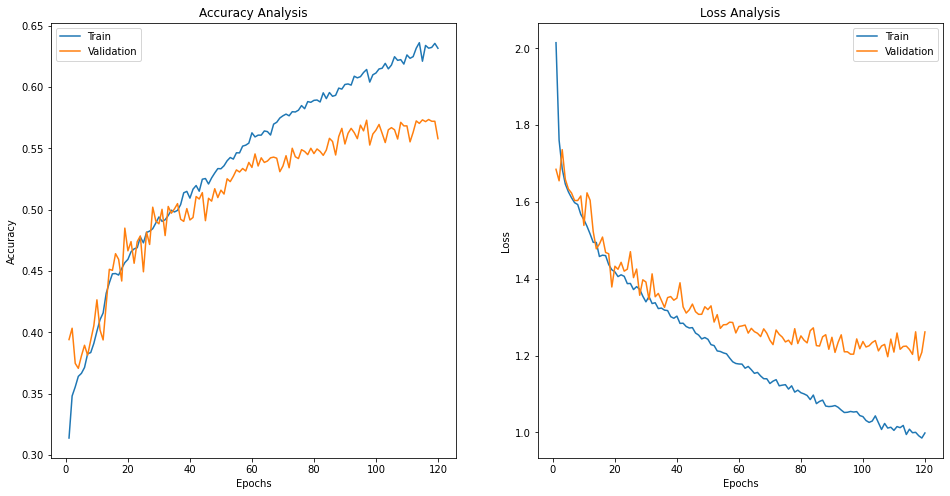

In [117]:
acc1, acc2, lt, lv = train(loss_func, optm, epochs,cnn,train_loader, valid_loader)

In [143]:
PATH = "cnnmelhorprovaamns.pth"
torch.save(cnn.state_dict(), PATH)

In [118]:
#Realizando a predição na validação
y_trueval = []
y_predval = []
cnn.eval()

with torch.no_grad():
  for inp_valid, label_valid in valid_loader:
                
      #alocando o input e a label na GPU
      inp_valid = inp_valid.to(device=device)
      label_valid = label_valid.to(device=device)
      
      #predição do modelo em cima do input
      predsval = cnn(inp_valid)
      predsval = nn.functional.softmax(predsval, dim=1)

      #preenchendo as listas referente ao y verdadeiro e y predito
      for i in range(len(label_valid)):
        y_trueval.append(int(label_valid[i].item()))
        y_predval.append(int(torch.argmax(predsval[i]).item()))

In [119]:
y_trueval = torch.tensor(y_trueval)
y_predval = torch.tensor(y_predval)

In [120]:
#Vendo os resultados/métricas para a validação
from torchmetrics import ConfusionMatrix
from sklearn.metrics import ConfusionMatrixDisplay
#montando a matriz de confusão
confmat = ConfusionMatrix(num_classes=7)
confmat(y_predval, y_trueval)

tensor([[146,  15,  71,  52,  16,   7,   2],
        [ 35, 130,  84,  40,  31,  18,   0],
        [ 51,  18, 605,  71,  61,  32,   3],
        [ 74,  37, 118, 343, 115,  10,   0],
        [ 32,  20,  50,  83, 415,   7,   0],
        [ 17,  26, 225,  24,  40, 282,   0],
        [  6,   0,  22,   4,   9,   3,   8]])

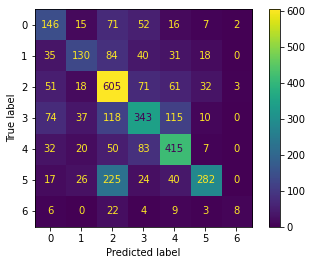

In [121]:
matrizconfusao = confmat(y_predval,y_trueval)
disp = ConfusionMatrixDisplay(confusion_matrix=np.array(matrizconfusao))
disp.plot()
plt.show()

In [122]:
from sklearn.metrics import classification_report
#{"fear":0, "disgust":1, "happy":2, "sad":3, "neutral":4, "angry":5, "surprise":6}
target_names = ['Fear', 'Disgust', 'Happy','Sad','Neutral','Angry','Surprise']
report = classification_report(np.array(y_trueval),np.array(y_predval),target_names= target_names)
print(report)

              precision    recall  f1-score   support

        Fear       0.40      0.47      0.44       309
     Disgust       0.53      0.38      0.45       338
       Happy       0.51      0.72      0.60       841
         Sad       0.56      0.49      0.52       697
     Neutral       0.60      0.68      0.64       607
       Angry       0.79      0.46      0.58       614
    Surprise       0.62      0.15      0.25        52

    accuracy                           0.56      3458
   macro avg       0.57      0.48      0.50      3458
weighted avg       0.58      0.56      0.55      3458



In [123]:
#Captando os dados de teste com ruído
ANNOTATIONS_FILE = "metadata/testeravdessruidoso.csv"
SAMPLE_RATE = 16000
NUM_SAMPLES = 4*16000

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)
test_data = SerDataset(ANNOTATIONS_FILE,mel_spectrogram,SAMPLE_RATE,NUM_SAMPLES,device)

print(f"There are {len(test_data)} samples in the dataset.")

There are 1144 samples in the dataset.


In [124]:
#criando o dataloader
test_loader= DataLoader(dataset = test_data, batch_size = batch_size, shuffle=True)

In [126]:
#sessão de teste com ruído

#lista para armazenar os y verdadeiros
y_truetest = []
#lista para armazenar os y preditos
y_predtest = []

cnn.eval()

with torch.no_grad():
  for inp_test, label_test in test_loader:
                
      #alocando o input e a label na GPU
      inp_test = inp_test.to(device=device)
      label_test = label_test.to(device=device)
      
      #predição do modelo em cima do input
      preds3 = cnn(inp_test)
      preds3 = nn.functional.softmax(preds3, dim=1)

      #preenchendo as listas referente ao y verdadeiro e y predito
      for i in range(len(label_test)):
        y_truetest.append(int(label_test[i].item()))
        y_predtest.append(int(torch.argmax(preds3[i]).item()))

In [127]:
y_truetest = torch.tensor(y_truetest)
y_predtest = torch.tensor(y_predtest)

In [129]:
##Vendo os resultados/métricas para o teste com ruído
#montando a matriz de confusão
confmat = ConfusionMatrix(num_classes=7)
confmat(y_predtest, y_truetest)

tensor([[  5,   6, 123,  16,  18,   8,   0],
        [  2,  23, 103,  37,   7,   4,   0],
        [  4,  13, 117,  27,  11,   4,   0],
        [  1,   5,  74,  77,  19,   0,   0],
        [  4,  15,  33,  28,   8,   0,   0],
        [  0,  14,  80,   7,   9,  66,   0],
        [  1,  12, 132,  16,   6,   9,   0]])

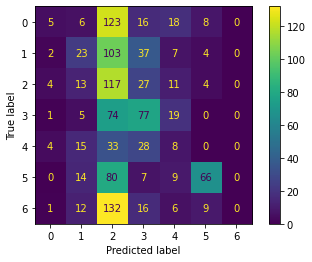

In [130]:
matrizconfusao = confmat(y_predtest,y_truetest)
disp = ConfusionMatrixDisplay(confusion_matrix=np.array(matrizconfusao))
disp.plot()
plt.show()

In [131]:
from sklearn.metrics import classification_report
#{"fear":0, "disgust":1, "happy":2, "sad":3, "neutral":4, "angry":5, "surprise":6}
target_names = ['Fear', 'Disgust', 'Happy','Sad','Neutral','Angry','Surprise']
report = classification_report(np.array(y_truetest),np.array(y_predtest),target_names= target_names)
print(report)

              precision    recall  f1-score   support

        Fear       0.29      0.03      0.05       176
     Disgust       0.26      0.13      0.17       176
       Happy       0.18      0.66      0.28       176
         Sad       0.37      0.44      0.40       176
     Neutral       0.10      0.09      0.10        88
       Angry       0.73      0.38      0.49       176
    Surprise       0.00      0.00      0.00       176

    accuracy                           0.26      1144
   macro avg       0.28      0.25      0.21      1144
weighted avg       0.29      0.26      0.22      1144



C:\Users\heloi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\heloi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\heloi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [132]:
#Captando os dados para o teste sem ruído
ANNOTATIONS_FILE = "metadata/testeravdess.csv"
SAMPLE_RATE = 16000
NUM_SAMPLES = 4*16000

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)
test_data2 = SerDataset(ANNOTATIONS_FILE,mel_spectrogram,SAMPLE_RATE,NUM_SAMPLES,device)

print(f"There are {len(test_data2)} samples in the dataset.")

There are 1144 samples in the dataset.


In [133]:
#Criando o dataloader
test_loader2= DataLoader(dataset = test_data2, batch_size = batch_size, shuffle=True)

In [134]:
#sessão de teste sem ruído

#lista para armazenar os y verdadeiros
y_truetest2 = []
#lista para armazenar os y preditos
y_predtest2 = []

cnn.eval()

with torch.no_grad():
  for inp_test, label_test in test_loader2:
                
      #alocando o input e a label na GPU
      inp_test = inp_test.to(device=device)
      label_test = label_test.to(device=device)
      
      #predição do modelo em cima do input
      preds3 = cnn(inp_test)
      preds3 = nn.functional.softmax(preds3, dim=1)

      #preenchendo as listas referente ao y verdadeiro e y predito
      for i in range(len(label_test)):
        y_truetest2.append(int(label_test[i].item()))
        y_predtest2.append(int(torch.argmax(preds3[i]).item()))

In [139]:
y_truetest2 = torch.tensor(y_truetest2)
y_predtest2 = torch.tensor(y_predtest2)

In [140]:
#Vendo os resultados/métricas para os testes sem ruído
#montando a matriz de confusão
confmat = ConfusionMatrix(num_classes=7)
confmat(y_predtest2, y_truetest2)

tensor([[  3,   0, 130,  19,  10,  14,   0],
        [  0,   2, 124,  25,  10,  13,   2],
        [  1,   0, 141,   8,  15,  10,   1],
        [  1,   0,  97,  61,  16,   0,   1],
        [  0,   0,  39,  26,  23,   0,   0],
        [  0,   2,  75,   3,   5,  91,   0],
        [  1,   0, 148,  12,   3,  12,   0]])

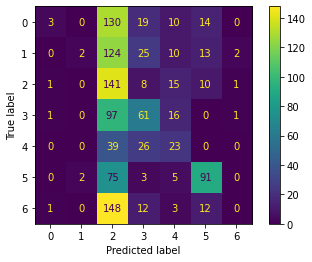

In [141]:
matrizconfusao = confmat(y_predtest2,y_truetest2)
disp = ConfusionMatrixDisplay(confusion_matrix=np.array(matrizconfusao))
disp.plot()
plt.show()

In [142]:
from sklearn.metrics import classification_report
#{"fear":0, "disgust":1, "happy":2, "sad":3, "neutral":4, "angry":5, "surprise":6}
target_names = ['Fear', 'Disgust', 'Happy','Sad','Neutral','Angry','Surprise']
report = classification_report(np.array(y_truetest2),np.array(y_predtest2),target_names= target_names)
print(report)

              precision    recall  f1-score   support

        Fear       0.50      0.02      0.03       176
     Disgust       0.50      0.01      0.02       176
       Happy       0.19      0.80      0.30       176
         Sad       0.40      0.35      0.37       176
     Neutral       0.28      0.26      0.27        88
       Angry       0.65      0.52      0.58       176
    Surprise       0.00      0.00      0.00       176

    accuracy                           0.28      1144
   macro avg       0.36      0.28      0.22      1144
weighted avg       0.37      0.28      0.22      1144

